# Lab 2b: getting started with APCEMM
**Tristan Abbott (tristan.abbott@breakthroughenergy.org)**

This lab provides an introduction to the Aircraft Plume Chemistry Emission and Microphysics Model (APCEMM), an intermediate-complexity contrail model developed at the [MIT Laboratory for Aviation and the Environment](https://lae.mit.edu/), and demonstrates how to use a [pycontrails](https://py.contrails.org/) interface to APCEMM to easily run APCEMM using real-world flight and meteorology data.

## Building APCEMM

APCEMM (https://github.com/MIT-LAE/APCEMM) is written in C++ and must be compiled before use. The build process is straightforward but can take up to an hour if dependencies (managed by vcpkg) also have to be built. The first cell below contains commands for building APCEMM locally, with the source code pinned to the most recent commit hash tested in the pycontrails interface. The second cell downloads and unzips the result from building APCEMM in Colab.

Lab attendees should run the second cell to download the pre-built version. (This approach is somewhat fragile--the pre-built version may not work if different Colab instances run on sufficiently different architectures--but building APCEMM from scratch would take up most of the lab.)

In [30]:
# build APCEMM locally (~45 minutes)
!git clone https://github.com/MIT-LAE/APCEMM ~/APCEMM && \
    cd ~/APCEMM && \
    git reset --hard 9d8e1ee && \
    git submodule update --init --recursive && \
    mkdir build && \
    cd build && \
    cmake ../Code.v05-00 && \
    cmake --build .

Cloning into '/home/ext_tristan_abbott_breakthroughe/APCEMM'...
remote: Enumerating objects: 10206, done.
remote: Counting objects: 100% (527/527), done.
remote: Compressing objects: 100% (277/277), done.
remote: Total 10206 (delta 247), reused 480 (delta 231), pack-reused 9679
Receiving objects: 100% (10206/10206), 27.07 MiB | 37.36 MiB/s, done.
Resolving deltas: 100% (6466/6466), done.
HEAD is now at 9d8e1ee Bugfixes for LAGRID model
Submodule 'Code.v05-00/submodules/vcpkg' (https://github.com/Microsoft/vcpkg.git) registered for path 'Code.v05-00/submodules/vcpkg'
Cloning into '/home/ext_tristan_abbott_breakthroughe/APCEMM/Code.v05-00/submodules/vcpkg'...
Submodule path 'Code.v05-00/submodules/vcpkg': checked out '2a6371b01420d8820d158b4707e79931feba27aa'
-- Bootstrapping vcpkg before install
-- Bootstrapping vcpkg before install - done
-- Running vcpkg install
Fetching registry information from https://github.com/microsoft/vcpkg (HEAD)...
Detecting compiler hash for triplet x64-linu

In [ ]:
# download results from building APCEMM in Colab (<5 minutes)
!cd ~ && wget https://storage.googleapis.com/2024-06-contrails-workshop/apcemm/APCEMM.zip && unzip APCEMM.zip && rm APCEMM.zip

## Installing pycontrails

This command installs pycontrails plus all optional dependencies besides `jupyter`, which conflicts with Colab requirements. It also installs
- `pyarrow`: to read parquet files

In [347]:
!pip install "pycontrails[ecmwf,gcp,gfs,goes,pyproj,vis,zarr] @ git+https://github.com/contrailcirrus/pycontrails@feature/apcemm-interface"
!pip install pyarrow

  Cloning https://github.com/contrailcirrus/pycontrails (to revision feature/apcemm-interface) to /tmp/pip-install-riv1ts4w/pycontrails_f5db84be249644a68e8716a14e52e9c2
  Running command git clone --filter=blob:none --quiet https://github.com/contrailcirrus/pycontrails /tmp/pip-install-riv1ts4w/pycontrails_f5db84be249644a68e8716a14e52e9c2
  Running command git checkout -b feature/apcemm-interface --track origin/feature/apcemm-interface
  Switched to a new branch 'feature/apcemm-interface'
  branch 'feature/apcemm-interface' set up to track 'origin/feature/apcemm-interface'.
  Resolved https://github.com/contrailcirrus/pycontrails to commit 449fed99caf63e1e00efb507f3301eb82ebebb2e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyarrow-16.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-16.1.0-cp312-cp312-manylinux_2_28_x86_64.whl (40.8 MB)


## Case 1: APCEMM with idealized meteorology

We will use an idealized case (a contrail that forms in an ISSR of finite depth and limited time duration) to demonstrate the workflow for a single APCEMM simulation.

### Step 1a: constructing meteorology input file

APCEMM expects meteorology data to be provided in a netCDF file that contains a timeseries of atmospheric profiles along the Lagrangian trajectory of an advected contrail segment. Note that the trajectory of the advected segment must be estimated *before* running APCEMM. Unlike CoCiP, APCEMM does not internally track changes to contrail position over time.

APCEMM requires pressure at t = 0 plus time-varying temperature, RH over ice, and segment-normal wind shear as input. We will use the pressure and temperature profiles from the [International Standard Atmosphere](https://en.wikipedia.org/wiki/International_Standard_Atmosphere), a simple step function for RHi, and a constant value of 0.01 1/s for segment-normal shear. 

In [248]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [264]:
z = np.linspace(0, 20, 41)  # altitude (km)
t = np.linspace(0, 4, 49)  # elapsed time (hours)

In [266]:
zz, tt = np.meshgrid(z, t, indexing="ij")

In [267]:
p = np.where(
    z < 11.0,
    101325*(1 - 6.5*z/288.15)**(9.80/(6.5e-3*287)),
    22632*np.exp(-9.80*(z - 11)*1e3/(287*216.65))
)
T = np.where(zz < 11.0, 288.15 - 6.5*zz, 216.65)
rhi = np.where((tt <= 0.5) & (zz > 9) & (zz < 11), 1.2, 0.2)
shear = np.full_like(zz, 0.01)

In [268]:
ds = xr.Dataset(data_vars = {
    "pressure": (("altitude",), p/100, {"units": "hPa"}),
    "temperature": (("altitude", "time"), T, {"units": "K"}),
    "relative_humidity_ice": (("altitude", "time"), rhi*100, {"units": "percent"}),
    "shear": (("altitude", "time"), shear, {"units": "1/s"})
}, coords = {
    "altitude": ("altitude", z, {"units": "km"}),
    "time": ("time", t, {"units": "hours"})
})  

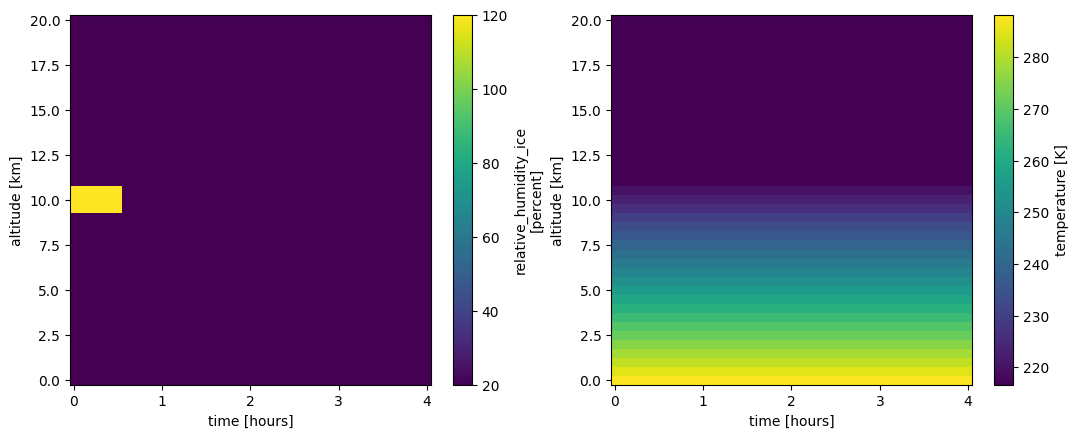

In [269]:
plt.figure(figsize=(12.8, 4.8))
plt.subplot(121)
ds["relative_humidity_ice"].plot()
plt.subplot(122)
ds["temperature"].plot()

### Step 1b: constructing input YAML file

Most APCEMM input parameters are configured in a YAML file. The file format is largely self-describing, and examples distributed with APCEMM include explanatory comments. We will generate the YAML file using some pycontrails utilities that expose many (but, for now, not all) of the YAML file parameters.

The pycontrails utilities require that the user provide
- the initial exhaust plume location (we will pick an arbitrary location)
- meteorological conditions at the point of emission (we will derive these from the idealized meteorology dataset)
- aircraft performance and emissions parameters (we will use nominal values)

Other YAML parameters are set to reasonable default values but can be overriden by the user. Note that the default time step for APCEMM numerics is set to 1 minute, a conservative value that is likely shorter than required.

In [270]:
from pycontrails.models.apcemm import utils
from pycontrails.models.apcemm.inputs import APCEMMInput
from pycontrails.physics import thermo

In [271]:
iz = 20  # form contrail at 10 km
theta = T[:,0]*(p[0]/p)**(287/1000)
params = APCEMMInput(
    # required parameters
    longitude=0,
    latitude=45,
    day_of_year=1,
    hour_of_day=12,
    air_pressure=p[iz],
    air_temperature=T[iz,0],
    rhw=rhi[iz,0]*thermo.e_sat_ice(T[iz,0])/thermo.e_sat_liquid(T[iz,0]),
    normal_shear=shear[iz,0],
    brunt_vaisala_frequency=np.sqrt((theta[iz+1] - theta[iz-1])/(z[iz+1] - z[iz-1])/theta[iz]),
    nox_ei=10e-3,
    co_ei=1e-3,
    hc_ei=0.6e-3,
    so2_ei=1.2e-3,
    nvpm_ei_m=0.008e-3,
    soot_radius=20e-9,
    fuel_flow=0.7,
    aircraft_mass=1e5,
    true_airspeed=260.0,
    n_engine=2,
    wingspan=35,
    core_exit_temp=550,
    core_exit_area=1,
    # optional parameters
    max_age=np.timedelta64(4, "h"),  # stop after no more than 4 hours
    dt_input_met=np.timedelta64(5, "m"),  # must match time step of met input file
    dt_apcemm_nc_output=np.timedelta64(5, "m")  # frequency of netcdf output files
)

### Step 2: write input files to disk and run APCEMM

In [272]:
import os

In [273]:
!rm -r ~/APCEMM_run/case_1

In [274]:
rundir = os.path.expanduser("~/APCEMM_run/case_1")
os.makedirs(rundir, exist_ok=True)

with open(os.path.join(rundir, "input.yaml"), "w") as f:
    yaml = utils.generate_apcemm_input_yaml(params)
    f.write(yaml)

ds.to_netcdf(os.path.join(rundir, "input.nc"))

In [275]:
!cd ~/APCEMM_run/case_1 && ~/APCEMM/build/APCEMM input.yaml

 -> Running case 0 on thread 0
running epm... 
Calculated Timestep: 1[min]
/home/ext_tristan_abbott_breakthroughe/APCEMM_run/case_1/out
Saving TS_AERO files to: /home/ext_tristan_abbott_breakthroughe/APCEMM_run/case_1/out/ts_aerosol_case0_hhmm.nc
Temperature      = 223.178 K
RHw              = 73.3714 %
RHi              = 120 %
Saturation depth = 600.721 m
Ice_den=225.403
Parameterized vortex sinking survival fraction: 1
Initial Contrail Width: 125.331
Initial Contrail Depth: 35.6737
EPM Num Particles: 7.91458e+11
Initial Num Particles: 7.91458e+11
Initial Ice Mass: 0.0286865
Save Complete


 - Time step: 1 out of 241
 -> Solar time: 12 [hr]
Running Transport
Running ice growth...
Updating Met...
Remapping... 
dx: 20, dy: 5
Num Particles: 6.82395e+11
Ice Mass: 0.0522369
Saving Aerosol... 


 - Time step: 2 out of 241
 -> Solar time: 12.0167 [hr]
Running Transport
Running ice growth...
Updating Met...
Remapping... 
dx: 20, dy: 5
Num Particles: 6.71599e+11
Ice Mass: 0.0929497
Saving Aero

### Step 3: view output

The APCEMM simulation created two types output files inside a subdirectory called `out`:
- `Micro000000.out`: output from the "early plume model"; i.e., the parameterization of the aircraft exhaust plume and downwash vortex, formatted as a CSV file
- `ts_aerosol_case0_HHMM.nc`: output from a finite volume model of the contrail cross-section initialized from the early plume model, formatted as netCDF files with HHMM replaced by the hour and minute of the simulation when each file was written.

In [278]:
import pandas as pd

The early plume model resolves the transient spike in relative humidity as the exhaust plume mixes with ambient air:

In [668]:
df = pd.read_csv(os.path.join(rundir, "out", "Micro000000.out"), skiprows=[1]).rename(columns=lambda x: x.strip())

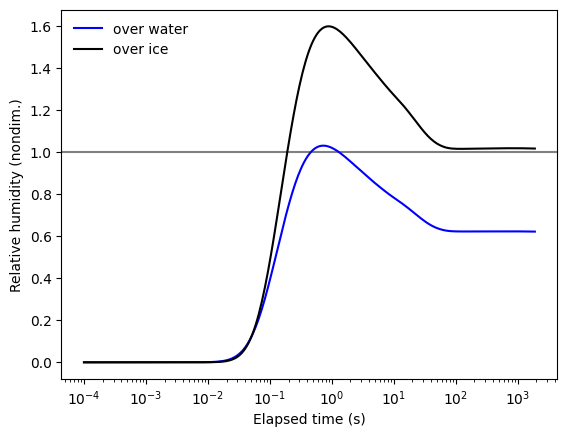

In [669]:
plt.plot(df["Time [s]"], df["RH_w [-]"], "b-", label="over water")
plt.plot(df["Time [s]"], df["RH_i [-]"], "k-", label="over ice")
plt.xlabel("Elapsed time (s)")
plt.ylabel("Relative humidity (nondim.)")
plt.gca().set_xscale("log")
plt.gca().axhline(y=1, color="gray", zorder=-1)
plt.legend(loc="upper left", frameon=False)

The finite-volume model simulates the evolution of the contrail that forms from the exhaust plume. It relaxes the Gaussian plume assumption used by CoCiP...

Text(0.98, 0.98, '02:30')

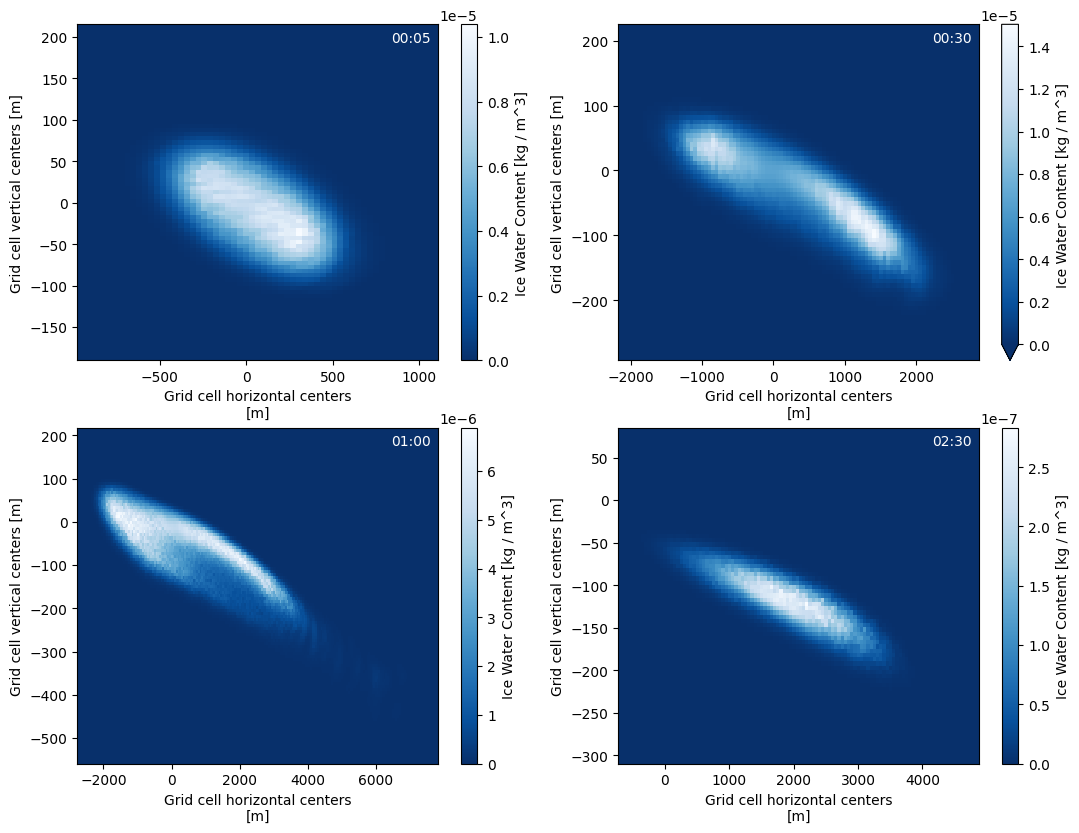

In [305]:
plt.figure(figsize=(12.8, 9.6))
plt.subplot(221)
ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0010.nc"), decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("00:10", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(222)
ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0030.nc"), decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("00:30", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(223)
ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0100.nc"), decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("01:00", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(224)
ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0230.nc"), decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate("02:30", xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

... and explicitly simulates the evolution of the ice crystal size distribution.

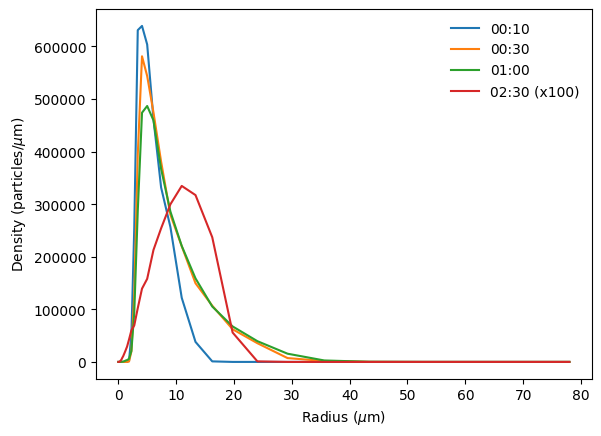

In [323]:
plt.figure()

ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0010.nc"), decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="00:10")

ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0030.nc"), decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="00:30")

ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0100.nc"), decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6, label="01:00")

ds = xr.open_dataset(os.path.join(rundir, "out", "ts_aerosol_case0_0230.nc"), decode_cf=False)
plt.plot(ds["r"]*1e6, ds["Overall size distribution"]/1e6*100, label="02:30 (x100)")

plt.xlabel(r"Radius ($\mu$m)")
plt.ylabel(r"Density (particles/$\mu$m)")
plt.legend(loc="upper right", frameon=False)

## Case 2: APCEMM on a real-world flight

We'll select an IAGOS flight between San Diego and Frankfurt in early February 2019 and use the pycontrails APCEMM interface to run APCEMM simulations initialized at a couple of waypoints. The interface is designed to be similar to other pycontrails models: you load meteorology data into a [MetDataset](https://py.contrails.org/api/pycontrails.MetDataset.html#pycontrails.MetDataset), create an [APCEMM]() model, and call the model's `eval` method on a [Flight](https://py.contrails.org/api/pycontrails.core.flight.html#pycontrails.core.flight.Flight) instance.

In [610]:
import cartopy.crs as ccrs
import matplotlib.dates as mdates

from pycontrails.core import MetDataset, Flight
from pycontrails.models.apcemm import APCEMM
from pycontrails.models.issr import ISSR
from pycontrails.models.humidity_scaling import HistogramMatching
from pycontrails.models.ps_model import PSFlight

### Step 1: load meteorology and flight data

The required data is staged in a public cloud bucket for this lab. After loading the data, we'll use the pycontrails [ISSR](https://py.contrails.org/api/pycontrails.models.issr.html#pycontrails.models.issr.ISSR) model to quickly compute and plot ERA5 RHi at the two waypoints where we'll run APCEMM.

In [611]:
ds = xr.open_zarr("gs://2024-06-contrails-workshop/apcemm/era5.zarr")
met = MetDataset(ds, provider="ECMWF", dataset="ERA5", product="reanalysis")

In [612]:
df = pd.read_parquet("gs://2024-06-contrails-workshop/apcemm/iagos.pq")
flight = Flight(data=df, attrs={"flight_id": "0"}).resample_and_fill("1min")

In [613]:
pcr = PCR(met=met, humidity_scaling=HistogramMatching())
result = pcr.eval(flight)

In [614]:
waypoints = [180, 300]

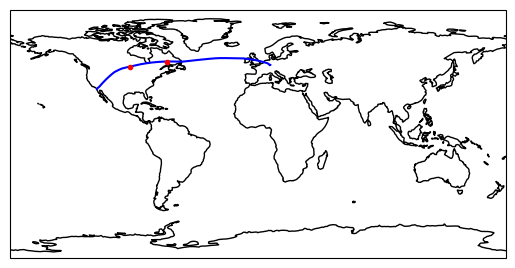

In [615]:
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.plot(flight["longitude"], flight["latitude"], "b-", transform=ccrs.Geodetic())
for idx in waypoints:
    ax.plot(flight["longitude"][idx], flight["latitude"][idx], "r.", transform=ccrs.Geodetic())

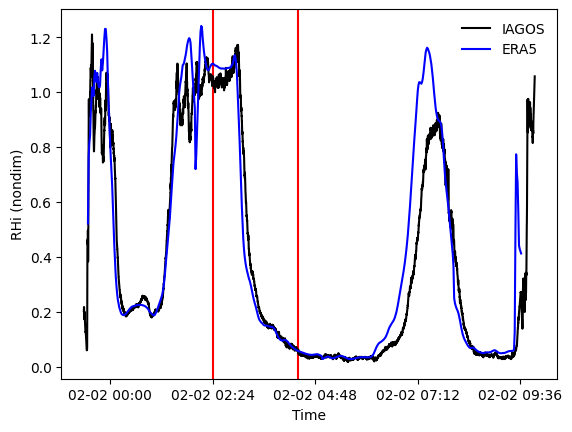

In [616]:
plt.plot(df["time"], df["rhi"], "k-", label="IAGOS")
plt.plot(result["time"], result["rhi"], "b-", label="ERA5")
plt.legend(loc="best", frameon=False)
plt.xlabel("Time")
plt.ylabel("RHi (nondim)")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
for idx in waypoints:
    plt.gca().axvline(flight["time"][idx], color="red", zorder=-1)

### Step 2: create and evaluate an `APCEMM` model

This model automates the steps we did by hand before running the idealized APCEMM case earlier in the lab. Specifically, it
- runs an aircraft performance model (in this case [PSFlight](https://py.contrails.org/api/pycontrails.models.ps_model.PSFlight.html)) to compute performance and emissions parameters,
- combines results from the aircraft performance model and meteorology data to create input YAML files, 
- runs a [DryAdvection](https://py.contrails.org/notebooks/advection.html) model to estimate the Lagrangian trajectories of advected contrail segments,
- uses the computed trajectories plus the MetDataset passed to the model to create netCDF meteorology files in the format expected by APCEMM,
- creates run directories (under in `~/.cache/pycontrails/apcemm` by default, though this can be changed by passing a custom [DiskCacheStore](https://py.contrails.org/api/pycontrails.DiskCacheStore.html#pycontrails-diskcachestore) to the model) and writes YAML and netCDF input files to disk,
- runs APCEMM simulations, and
- does light postprocessing of APCEMM output.

To limit runtime, we'll set the maximum simulation duration to 6 hours and increase the APCEMM timestep to 10 minutes.

In [619]:
model = APCEMM(
    apcemm_path=os.path.expanduser("~/APCEMM/build/APCEMM"),
    met=met,
    max_age=np.timedelta64(6, "h"),
    aircraft_performance=PSFlight(),
    humidity_scaling=HistogramMatching(),
    apcemm_input_params=dict(
        dt_apcemm_nc_output=np.timedelta64(10, "m"),
        dt_apcemm_transport=np.timedelta64(10, "m"),
        dt_apcemm_coagulation=np.timedelta64(10, "m"),
        dt_apcemm_ice_growth=np.timedelta64(10, "m")
    ) 
)

In [620]:
result = model.eval(flight, waypoints=waypoints, n_jobs=1)

### Step 3: examine model output

Lagrangian trajectories of advected contrail segments are stored in `model.trajectories`. (Note that Lagrangian trajectories are computed for all waypoints, not just waypoints where APCEMM simulations are initialized, but we'll plot them only for waypoints where we ran simulations.)

In [687]:
model.trajectories

GeoVectorDataset [16 keys x 7308 length, 1 attributes]
	Keys: age, air_temperature, air_pressure, latitude, level, ..., time
	Attributes:
	time                [2019-02-01 23:54:00, 2019-02-02 15:24:00]
	longitude           [-116.391, 10.38]
	latitude            [33.196, 59.089]
	altitude            [5655.3, 11486.9]
	crs                 EPSG:4326

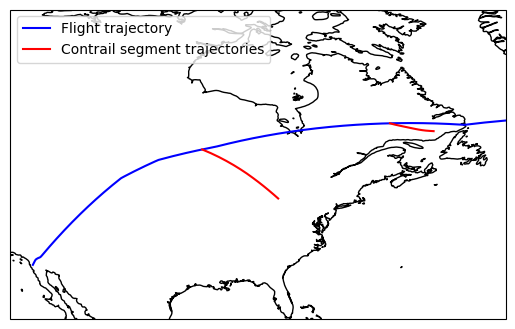

In [641]:
df = model.trajectories.dataframe

ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-120, -50, 25, 65], crs=ccrs.Geodetic())
ax.plot(flight["longitude"], flight["latitude"], "b-", transform=ccrs.Geodetic(), label="Flight trajectory")
for i, waypoint in enumerate(waypoints):
    label = "Contrail segment trajectories" if i == 0 else ""
    head = flight.dataframe[flight.dataframe.index == waypoint]
    tail = df[df["waypoint"] == waypoint]
    traj = pd.concat((head, tail))
    ax.plot(traj["longitude"], traj["latitude"], "r-", transform=ccrs.Geodetic(), label=label)
ax.legend(loc="upper left")

The output from `model.eval` stores quantities calculated for APCEMM input files plus the status of APCEMM simulations initialized at each waypoint.

In [686]:
result

Flight [47 keys x 633 length, 24 attributes]
	Keys: longitude, latitude, altitude, time, flight_id, ..., status
	Attributes:
	time                [2019-02-01 23:24:00, 2019-02-02 09:56:00]
	longitude           [-116.774, 9.097]
	latitude            [32.64, 55.103]
	altitude            [714.7, 11278.9]
	flight_id           0
	crs                 EPSG:4326
	aircraft_type       B738
	fuel                JetA(fuel_name='Jet A-1', q_fuel=43130000.0, hydrogen_content=13.8, ei_co2=3....
	aircraft_performance_modelPSFlight
	n_engine            2
	wingspan            34.3
	max_mach            0.82
	max_altitude        12496.800000000001
	total_fuel_burn     27876.614164979575
	engine_uid          01P11CM116
	gaseous_data_source FFM2
	nvpm_data_source    ICAO EDB
	total_co2           88062.22414717049
	total_h2o           34288.235422924874
	total_so2           33.451936997975494
	total_sulphates     0.6826925917954182
	total_oc            0.5575322832995915
	total_nox           318.413309243746
	total_co            12.04841308584799
	total_hc            1.1286484556503722
	total_nvpm_mass     1.524955407541762
	total_nvpm_number   3.5236614388310934e+19
	so2_ei              0.0012

"Incomplete" indicates that a persistent contrail formed but did not dissipate before the maximum simulation time was reached.

In [646]:
result.dataframe[result.dataframe["waypoint"] == 180]["status"]

180    Incomplete
Name: status, dtype: object

"NoWaterSaturation" indicates that no contrail formed because the exhaust plume never reached saturation over liquid water while mixing with ambient air.

In [650]:
result.dataframe[result.dataframe["waypoint"] == 300]["status"]

300    NoWaterSaturation
Name: status, dtype: object

"NoSimulation" indicates that no APCEMM simulation was initialize at the waypoint:

In [651]:
result.dataframe[result.dataframe["waypoint"] == 400]["status"]

400    NoSimulation
Name: status, dtype: object

Output from the APCEMM early plume model is stored in a DataFrame in `model.vortex`:

In [685]:
model.vortex

,waypoint,time,Tracer [-],Temp. [K],Pres. [Pa],H2O [/cm3],RH_i [-],RH_w [-],SO4 [/cm3],SO4g [/cm3],SO4l [/cm3],SO4s [/cm3],SO4Sat [-],HNO3 [/cm3],HNO3Sat[-],Part[/cm3],Rad[mum],Theta1[-],Theta2[-],
0,180,2019-02-02 02:24:00.000100000,1.000000,550.0000,23863.88,6.940976e+16,0.000020,0.000083,5.910097e+10,5.910097e+10,0.0,0.0,6.997755e-08,6.524999e+11,9.660829e-86,1.863155e+06,0.017468,0.000000,0.000000e+00,
1,180,2019-02-02 02:24:00.000105764,1.000000,550.0000,23863.88,6.940976e+16,0.000020,0.000083,5.910097e+10,5.910076e+10,0.0,209642.9,6.997731e-08,6.524999e+11,9.660829e-86,1.863155e+06,0.017468,0.000006,5.935924e-26,
2,180,2019-02-02 02:24:00.000111860,1.000000,550.0000,23863.88,6.940976e+16,0.000020,0.000083,5.910097e+10,5.910054e+10,0.0,431366.9,6.997704e-08,6.524999e+11,9.660829e-86,1.863155e+06,0.017468,0.000012,1.221394e-25,
3,180,2019-02-02 02:24:00.000118307,1.000000,550.0000,23863.88,6.940976e+16,0.000020,0.000083,5.910097e+10,5.910030e+10,0.0,665868.1,6.997677e-08,6.524999e+11,9.660829e-86,1.863155e+06,0.017468,0.000019,1.885376e-25,
4,180,2019-02-02 02:24:00.000125126,1.000000,550.0000,23863.88,6.940976e+16,0.000020,0.000083,5.910097e+10,5.910005e+10,0.0,913882.6,6.997647e-08,6.524999e+11,9.660829e-86,1.863155e+06,0.017468,0.000026,2.587624e-25,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,300,2019-02-02 04:49:11.284000000,0.000027,223.8479,23853.88,8.287628e+13,0.059720,0.036755,4.544070e+06,1.187353e+06,3179439.0,177278.1,1.503890e+00,6.290677e+11,4.132273e-51,1.160858e+02,0.017729,0.077356,6.720955e-01,
596,300,2019-02-02 04:50:38.391000000,0.000024,223.8470,23853.88,8.244750e+13,0.059417,0.036568,4.176144e+06,1.150008e+06,2865773.0,160361.8,1.383264e+00,6.290677e+11,4.134220e-51,1.046384e+02,0.017729,0.077634,6.770583e-01,
597,300,2019-02-02 04:52:10.518000000,0.000022,223.8462,23853.88,8.206169e+13,0.059145,0.036400,3.845093e+06,1.116460e+06,2583545.0,145087.6,1.274707e+00,6.290677e+11,4.135973e-51,9.433826e+01,0.017729,0.077912,6.820928e-01,
598,300,2019-02-02 04:53:47.954000000,0.000020,223.8455,23853.88,8.171493e+13,0.058900,0.036249,3.547539e+06,1.086353e+06,2329874.0,131312.0,1.177119e+00,6.290677e+11,4.137549e-51,8.508035e+01,0.017729,0.078192,6.872000e-01,


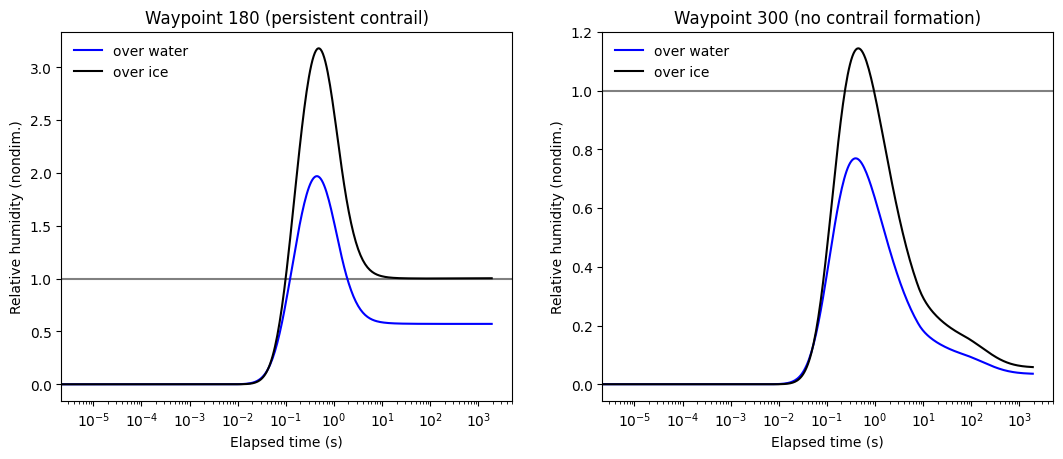

In [670]:
plt.figure(figsize=(12.8, 4.8))

df = model.vortex[model.vortex["waypoint"] == 180]
elapsed_time = (df["time"] - df["time"].min())/np.timedelta64(1, "s")
plt.subplot(121)
plt.plot(elapsed_time, df["RH_w [-]"], "b-", label="over water")
plt.plot(elapsed_time, df["RH_i [-]"], "k-", label="over ice")
plt.xlabel("Elapsed time (s)")
plt.ylabel("Relative humidity (nondim.)")
plt.gca().set_xscale("log")
plt.gca().axhline(y=1, color="gray", zorder=-1)
plt.title("Waypoint 180 (persistent contrail)")
plt.legend(loc="upper left", frameon=False)

df = model.vortex[model.vortex["waypoint"] == 300]
elapsed_time = (df["time"] - df["time"].min())/np.timedelta64(1, "s")
plt.subplot(122)
plt.plot(elapsed_time, df["RH_w [-]"], "b-", label="over water")
plt.plot(elapsed_time, df["RH_i [-]"], "k-", label="over ice")
plt.xlabel("Elapsed time (s)")
plt.ylabel("Relative humidity (nondim.)")
plt.gca().set_xscale("log")
plt.gca().axhline(y=1, color="gray", zorder=-1)
plt.title("Waypoint 300 (no contrail formation)")
plt.legend(loc="upper left", frameon=False)

Finally, paths to netCDF output from the finite-volume contrail cross-section model are stored in `model.contrail`:

In [684]:
model.contrail

,waypoint,time,path
0,180,2019-02-02 02:24:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
1,180,2019-02-02 02:34:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
2,180,2019-02-02 02:44:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
3,180,2019-02-02 02:54:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
4,180,2019-02-02 03:04:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
5,180,2019-02-02 03:14:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
6,180,2019-02-02 03:24:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
7,180,2019-02-02 03:34:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
8,180,2019-02-02 03:44:00,/home/ext_tristan_abbott_breakthroughe/.cache/...
9,180,2019-02-02 03:54:00,/home/ext_tristan_abbott_breakthroughe/.cache/...


Text(0.98, 0.98, '2019-02-02 08:24:00')

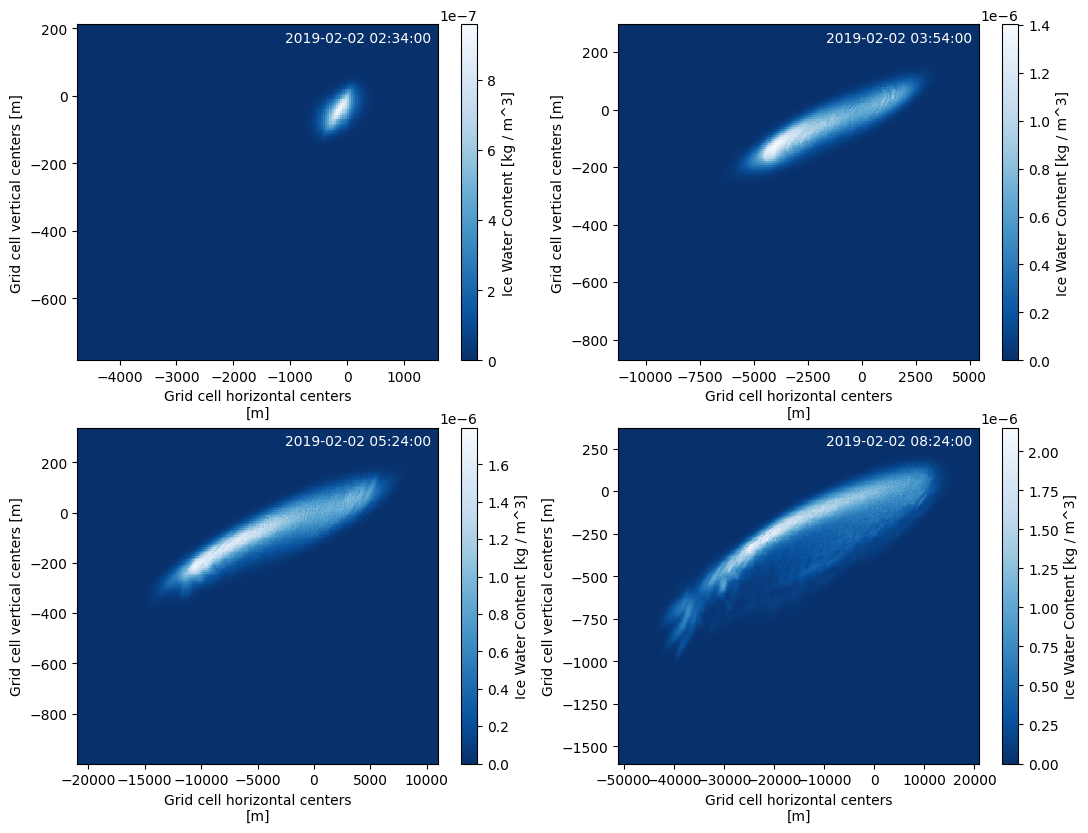

In [682]:
plt.figure(figsize=(12.8, 9.6))

plt.subplot(221)
df = model.contrail.iloc[1]
ds = xr.open_dataset(df["path"], decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate(df["time"], xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(222)
df = model.contrail.iloc[9]
ds = xr.open_dataset(df["path"], decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate(df["time"], xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(223)
df = model.contrail.iloc[18]
ds = xr.open_dataset(df["path"], decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate(df["time"], xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

plt.subplot(224)
df = model.contrail.iloc[36]
ds = xr.open_dataset(df["path"], decode_cf=False)
ds["IWC"].plot(cmap="Blues_r", vmin=0)
plt.annotate(df["time"], xy=(0.98, 0.98), xycoords="axes fraction", va="top", ha="right", color="white")

## Concluding remarks

- APCEMM is more expensive to run than CoCiP, but simulations can easily be parallelized across waypoints. If you're running on a large machine, the `n_jobs` parameter can be used in the `APCEMM` constructor or in `APCEMM.eval` to run multiple simulations in parallel.

- The pycontrails APCEMM interface is relatively immature. If you're interested in using it and it's missing features you need or you think you've found a bug, please get in touch or open an issue on [GitHub](https://github.com/contrailcirrus/pycontrails/issues). (And remember: you do not have to use pycontrails to use APCEMM!)

- APCEMM does not provide contrail radiative forcing as an output, though it provides all of the quantities needed to compute contrail radiative forcing offline, and this is a feature we would like to add to the interface eventually. If it's something you'd like to be able to use, please let us know.